In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import Data

In [162]:
# Read whatever csv from WRDS here
rawdata_df = pd.read_csv('../data/9ed72d66f17a8c88_csv.zip', nrows = 100000, low_memory = False)
rawdata_df.head()

,DATE,TIME_M,EX,SYM_ROOT,SYM_SUFFIX,PRICE
0,20190920,9:30:00.004081781,Q,FB,NaN,190.62
1,20190920,9:30:00.004084410,Q,FB,NaN,190.66
2,20190920,9:30:00.018928332,Q,FB,NaN,190.66
3,20190920,9:30:00.018929933,Q,FB,NaN,190.66
4,20190920,9:30:00.018933395,Q,FB,NaN,190.66


# Process Data

In [125]:
data_df = rawdata_df.query('EX != ["A", "M", "L", "D", "C"]').copy()

In [126]:
# Add datetime info
data_df['DATE TIME'] = data_df['DATE'].astype(str) + ' ' + data_df['TIME_M'].astype(str)
data_df['datetime'] = pd.to_datetime(data_df['DATE TIME'])
data_df['date'] = pd.to_datetime(data_df['DATE'].astype(str))

In [127]:
# Rename variables
data_df['ticker'] = data_df['SYM_ROOT']
data_df['log_price'] = np.log(data_df['PRICE'])

In [128]:
# Resample on a 5 minute basis
data_df = (
    data_df.set_index("datetime")
    .groupby(["ticker", "date"])
    .resample('5min', label = 'right')["log_price"]
    .last()
    .reset_index()
)


data_df["log_price"] = (
    data_df.sort_values(by="datetime")
    .groupby(["ticker", "date"])["log_price"]
    .fillna(method="ffill")
)

In [129]:
# Add more variables
data_df = data_df.sort_values(by="datetime")
data_df['price'] = np.exp(data_df['log_price'])
data_df["return"] = data_df.groupby(["ticker", "date"])["log_price"].diff(1)

In [142]:
data_df.head()

,ticker,date,datetime,log_price,price,return
0,AAPL,2019-09-20,2019-09-20 09:35:00,5.403398,222.16,NaN
0,AAPL,2019-09-20,2019-09-20 09:35:00,5.403398,222.16,NaN
0,AAPL,2019-09-20,2019-09-20 09:35:00,5.403398,222.16,NaN
1,AAPL,2019-09-20,2019-09-20 09:40:00,5.403713,222.23,0.000315
1,AAPL,2019-09-20,2019-09-20 09:40:00,5.403713,222.23,0.000315


# TEMP REMOVE

In [158]:
data_df = pd.read_csv('../data/clean/AAPL.csv')
data_df['datetime']=pd.to_datetime(data_df['datetime'])

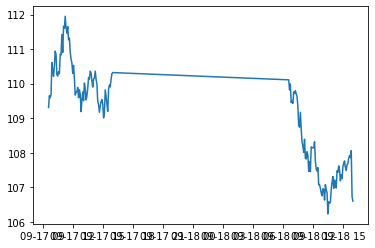

In [159]:
plot_data = data_df.sort_values(by = 'datetime')
plot_data = plot_data.loc[plot_data['datetime'] > pd.to_datetime('2020-09-17'),:]
plt.plot(plot_data['datetime'], plot_data['price'])

In [163]:
rawdata_df['datetime'] = pd.to_datetime(rawdata_df['DATE'].astype(str) + ' ' + rawdata_df['TIME_M'].astype(str))
rawdata_df = rawdata_df.sort_values(by = 'datetime')

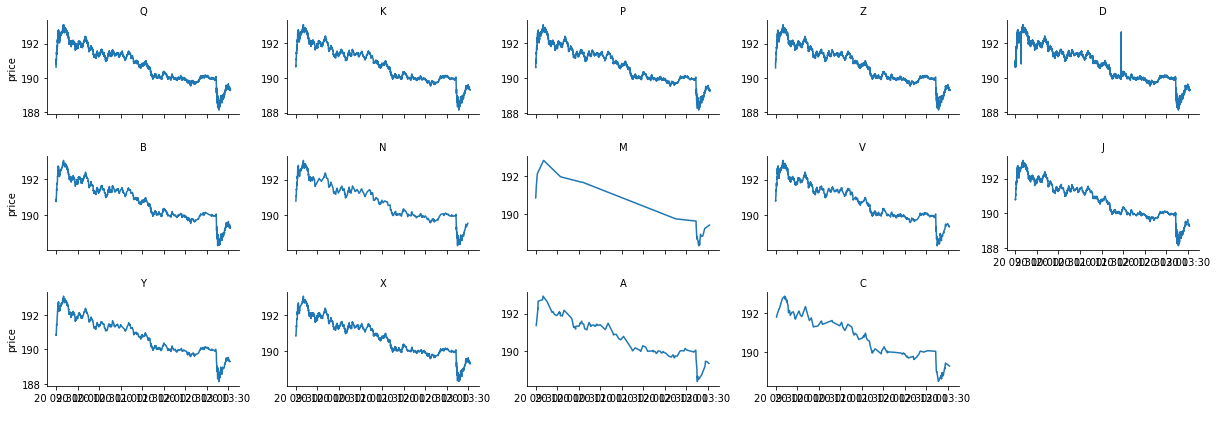

In [164]:
g = sns.FacetGrid(rawdata_df.query('DATE == 20190920'), col = 'EX', col_wrap = 5, sharex = True, aspect = 1.7, height = 2, sharey=False)
g = (g.map(plt.plot,'datetime', 'PRICE')
    .set_titles("{col_name}")
    .set_axis_labels(" ", "price")
)

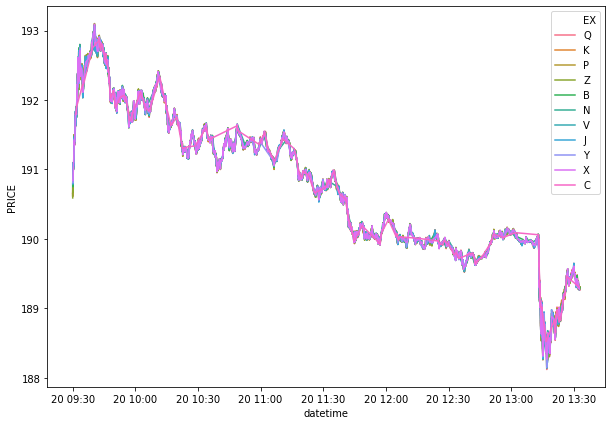

In [166]:
plt.figure(figsize = (10,7))
sns.lineplot(
    x="datetime",
    y="PRICE",
    data=rawdata_df.query('DATE == 20190920 & EX != ["A", "M", "L", "D"]'),
    hue="EX",
)

In [198]:
data_df['return_sq'] = np.square(data_df['return'])
data_df['return_power4'] = np.power(data_df['return'], 4)

In [199]:
# RV
data_daily_df = (
    data_df.groupby(["ticker", "date"])["return_sq"]
    .sum()
    .reset_index()
    .rename(columns={"return_sq": "daily_RV"})
)

# RV se
data_daily_df["se"] = np.sqrt(
    data_df.groupby(["ticker", "date"])["return_power4"].sum().reset_index()["return_power4"] * 2 / 3
)

In [200]:
import matplotlib.pyplot as plt

In [201]:
np.sqrt(2/3*data_df.query('date == "2019-09-23"')['return_power4'].sum())

8.953918287677393e-06

In [202]:
data_daily_df.iloc[1,3]

8.953918287677392e-06

In [204]:
data_daily_df

,ticker,date,daily_RV,se
0,GOOG,2019-09-20,0.000127,0.000037
1,GOOG,2019-09-23,0.000054,0.000009
2,GOOG,2019-09-24,0.000220,0.000041
3,GOOG,2019-09-25,0.000094,0.000022
4,GOOG,2019-09-26,0.000110,0.000020
...,...,...,...,...
247,GOOG,2020-09-14,0.001198,0.000186
248,GOOG,2020-09-15,0.001303,0.000220
249,GOOG,2020-09-16,0.001571,0.000216
250,GOOG,2020-09-17,0.001538,0.000226


In [208]:
data_daily_df.loc[data_daily_df['date']> pd.to_datetime('2020-08-02'),:].head()

,ticker,date,daily_RV,se
218,GOOG,2020-08-03,0.000735,0.000120
219,GOOG,2020-08-04,0.000890,0.000138
220,GOOG,2020-08-05,0.000910,0.000131
221,GOOG,2020-08-06,0.000404,0.000073
222,GOOG,2020-08-07,0.000462,0.000066


In [210]:
data_df.head()

,ticker,date,datetime,log_price,price,return,return_sq,return_power4
0,GOOG,2019-09-20,2019-09-20 09:35:00,7.121059,1237.76,NaN,NaN,NaN
1,GOOG,2019-09-20,2019-09-20 09:40:00,7.124301,1241.78,0.003243,1.051406e-05,1.105455e-10
2,GOOG,2019-09-20,2019-09-20 09:45:00,7.124712,1242.29,0.000411,1.686059e-07,2.842794e-14
3,GOOG,2019-09-20,2019-09-20 09:50:00,7.121156,1237.88,-0.003556,1.264664e-05,1.599375e-10
4,GOOG,2019-09-20,2019-09-20 09:55:00,7.120242,1236.75,-0.000913,8.340583e-07,6.956532e-13


In [221]:
rawdata_df.head()

,DATE,TIME_M,EX,SYM_ROOT,SYM_SUFFIX,PRICE
0,20190920,9:30:00.025559149,Q,GOOG,NaN,1234.75
1,20190920,9:30:00.271118326,Q,GOOG,NaN,1234.01
2,20190920,9:30:00.271126947,K,GOOG,NaN,1233.12
3,20190920,9:30:00.271166170,Q,GOOG,NaN,1234.01
4,20190920,9:30:00.271169340,Q,GOOG,NaN,1234.00


In [219]:
data_df.head()

,ticker,date,datetime,log_price,price,return
0,GOOG,2019-09-20,2019-09-20 09:35:00,7.121059,1237.76,NaN
1,GOOG,2019-09-20,2019-09-20 09:40:00,7.124357,1241.85,0.003299
2,GOOG,2019-09-20,2019-09-20 09:45:00,7.124808,1242.41,0.000451
3,GOOG,2019-09-20,2019-09-20 09:50:00,7.121156,1237.88,-0.003653
4,GOOG,2019-09-20,2019-09-20 09:55:00,7.120711,1237.33,-0.000444


Text(0.5, 1.0, 'GOOG Realized Variance (Daily)')

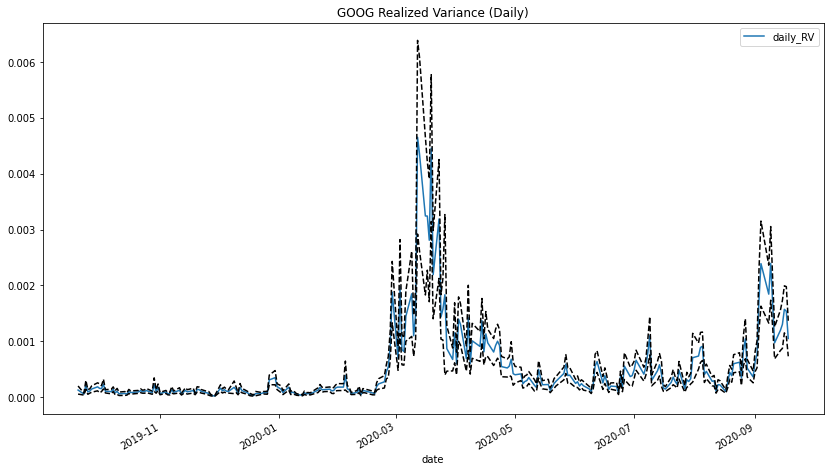

In [205]:
fig, ax = plt.subplots(figsize=(14,8))
data_daily_df.plot('date', 'daily_RV', ax = ax)
plt.plot(data_daily_df['date'], data_daily_df['daily_RV'] + 1.95*data_daily_df['se'], color = 'k', ls = 'dashed')
plt.plot(data_daily_df['date'], data_daily_df['daily_RV'] - 1.95*data_daily_df['se'], color = 'k', ls = 'dashed')
plt.title('GOOG Realized Variance (Daily)')

# Export Data

In [131]:
data_df.to_csv('../data/clean/GOOG.csv', index = False)

# Merge Exported Data

In [132]:
import os

In [133]:
data_df = pd.concat([pd.read_csv('../data/clean/' + y) for y in [x for x in os.walk('../data/clean')][0][2]])

In [134]:
data_df.groupby('ticker').count()

,date,datetime,log_price,price,return
ticker,,,,,
AAPL,58968,58968,58968,58968,58212
AMZN,58965,58965,58965,58965,58209
FB,58965,58965,58965,58965,58209
GOOG,58959,58959,58959,58959,58203
NFLX,58968,58968,58968,58968,58212


In [135]:
data_df['datetime'] = pd.to_datetime(data_df['datetime'])
data_df['date'] = data_df['datetime'].dt.date
data_df = data_df.sort_values(by = ['ticker', 'date', 'datetime'])

In [136]:
data_df.to_csv('../data/clean/faang_5min_prices.csv', index = False)